# Klasifikasi Cardiovascular dengan menggunakan metode Support Vector Machine

## Import Library yang diperlukan

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import pearsonr, spearmanr

## Load Datasets

In [25]:
cardio = pd.read_csv("cardiovascular.csv")
cardio

,Unnamed: 0,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,0.0,18393.0,1,168.0,62.0,110.0,80.0,0,0,0,0,1,0
1,1,1.0,20228.0,0,156.0,85.0,140.0,90.0,2,0,0,0,1,1
2,2,2.0,18857.0,0,165.0,64.0,130.0,70.0,2,0,0,0,0,1
3,3,3.0,17623.0,1,169.0,82.0,150.0,100.0,0,0,0,0,1,1
4,4,4.0,17474.0,0,156.0,56.0,100.0,60.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,69995,99993.0,19240.0,1,168.0,76.0,120.0,80.0,0,0,1,0,1,0
69996,69996,99995.0,22601.0,0,158.0,126.0,140.0,90.0,1,1,0,0,1,1
69997,69997,99996.0,19066.0,1,183.0,105.0,180.0,90.0,2,0,0,1,0,1
69998,69998,99998.0,22431.0,0,163.0,72.0,135.0,80.0,0,1,0,0,0,1


In [26]:
## ubah satuan umur ke tahun
def ageKategori(umur):
    umur = umur // 356
    if umur < 40:
        umur = 0
    elif umur < 50:
        umur = 1
    elif umur < 60:
        umur = 2
    elif umur < 70:
        umur = 3
    return umur
        
# cardio["age_year"] = cardio['age'] // 356
# cardio = cardio.drop(columns='age')
cardio["age"] = cardio["age"].apply(ageKategori)
cardio.head()

,Unnamed: 0,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,0.0,2,1,168.0,62.0,110.0,80.0,0,0,0,0,1,0
1,1,1.0,2,0,156.0,85.0,140.0,90.0,2,0,0,0,1,1
2,2,2.0,2,0,165.0,64.0,130.0,70.0,2,0,0,0,0,1
3,3,3.0,1,1,169.0,82.0,150.0,100.0,0,0,0,0,1,1
4,4,4.0,1,0,156.0,56.0,100.0,60.0,0,0,0,0,0,0


## Business Understanding

Tujuan :
membangun model prediksi yang mampu mengidentifikasi keberadaan penyakit kardiovaskular (CVD) pada pasien berdasarkan berbagai faktor, termasuk data obyektif, hasil pemeriksaan medis, dan perilaku yang dilaporkan oleh pasien. Deteksi dini CVD dapat menghasilkan intervensi yang tepat waktu, meningkatkan hasil kesehatan pasien, dan mengurangi biaya perawatan kesehatan.

### Data Understanding

dataset cardiovascular ini merupakan data klasifikasi untuk memprediksi status cardio atau penyakit jantung pada pasien berdasarkan 11 fitur yang datanya diambil dari 70.000 pasien. fitur di dapatkan dari informasi faktual (age, height, weight, dan gender), hasil pemeriksaan medis(tekanan darah sistolik, tekanan darah diastolik, kolestrol, dan glukosa), dan informasi yang diberikan pasien(smoke, alcohol, aktivitas fisik). 

#### Deskripsi Data:

Dataset ini berisi berbagai fitur yang dapat dikelompokkan sebagai berikut: (tambahkan tipe data, ukuran datanya, detailnya)

##### Fitur Obyektif ( informasi faktual ):

Age
    
    Tipe Data: Integer
    Deskripsi: Usia pasien dalam satuan hari. Fitur ini dapat dikonversi ke tahun untuk memudahkan interpretasi dan analisis.

Height

    Tipe Data: Integer
    Deskripsi: Tinggi badan pasien yang diukur dalam sentimeter.

Weight

    Tipe Data: Float
    Deskripsi: Berat badan pasien dalam kilogram. Fitur ini memiliki tipe data float untuk mengakomodasi nilai desimal yang mungkin muncul.

Gender

    Tipe Data: Kategori
    Deskripsi: Menunjukkan jenis kelamin pasien, umumnya dikodekan sebagai 1 untuk laki-laki dan 2 untuk perempuan.


##### Fitur Pemeriksaan (hasil pemeriksaan medis):

Tekanan darah sistolik (ap_hi)

    Tipe Data: Integer
    Deskripsi: Tekanan darah sistolik, yaitu tekanan maksimum di arteri saat jantung berdetak.

Tekanan darah diastolik (ap_lo)

    Tipe Data: Integer
    Deskripsi: Tekanan darah diastolik, yaitu tekanan dalam arteri antara detak jantung.

Kolestrol

    Tipe Data: Kategori
    Deskripsi: Kategori kadar kolesterol pasien, dengan tiga tingkat—1 untuk normal, 2 untuk di atas normal, dan 3 untuk jauh di atas normal.

Glukosa

    Tipe Data: Kategori
    Deskripsi: Kategori kadar glukosa darah pasien, dengan tiga tingkat—1 untuk normal, 2 untuk di atas normal, dan 3 untuk jauh di atas normal.


##### Fitur Subyektif ( informasi yang diberikan pasien ):

Smoking (smoke)

    Tipe Data: Binary
    Deskripsi: Variabel biner yang menunjukkan apakah pasien merokok atau tidak, biasanya dikodekan sebagai 1 untuk ya dan 0 untuk tidak.

Alcohol Intake (alco)

    Tipe Data: Binary
    Deskripsi: Variabel biner yang menunjukkan apakah pasien mengonsumsi alkohol, dengan kode 1 untuk ya dan 0 untuk tidak.

Physical Activity (active)

    Tipe Data: Binary
    Deskripsi: Variabel biner yang menunjukkan apakah pasien aktif secara fisik, dengan kode 1 untuk ya dan 0 untuk tidak.


Variabel Target:

Cardio

    Tipe Data: Binary
    Deskripsi: Variabel target yang menunjukkan keberadaan penyakit kardiovaskular pada pasien. Dikodekan sebagai 1 jika ada penyakit dan 0 jika tidak ada.


In [27]:
descriptive_stats = cardio.describe()
print("statistik deskriptif")
print(descriptive_stats)

statistik deskriptif
         Unnamed: 0            id           age        gender        height  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean   34999.500000  49972.419900      1.989157      0.349571    164.359229   
std    20207.403759  28851.302323      0.708613      0.476838      8.210126   
min        0.000000      0.000000      0.000000      0.000000     55.000000   
25%    17499.750000  25006.750000      1.000000      0.000000    159.000000   
50%    34999.500000  50001.500000      2.000000      0.000000    165.000000   
75%    52499.250000  74889.250000      2.000000      1.000000    170.000000   
max    69999.000000  99999.000000      3.000000      1.000000    250.000000   

             weight         ap_hi         ap_lo   cholesterol          gluc  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean      74.205690    128.817286     96.630414      0.366871      0.226457   
std       14.395757    154.011

In [28]:
label_counts = cardio["cardio"].value_counts()
label_counts

cardio
0    35021
1    34979
Name: count, dtype: int64

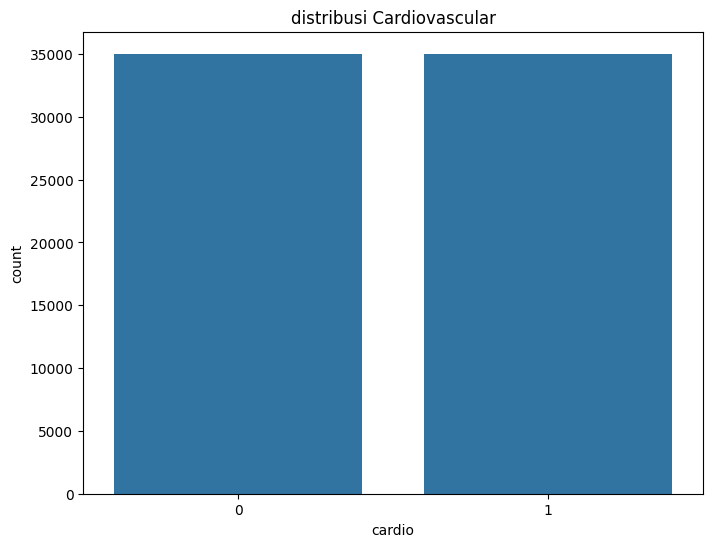

In [29]:
plt.figure(figsize=(8,6))
sns.countplot(x='cardio', data=cardio)
plt.title("distribusi Cardiovascular")
plt.show()

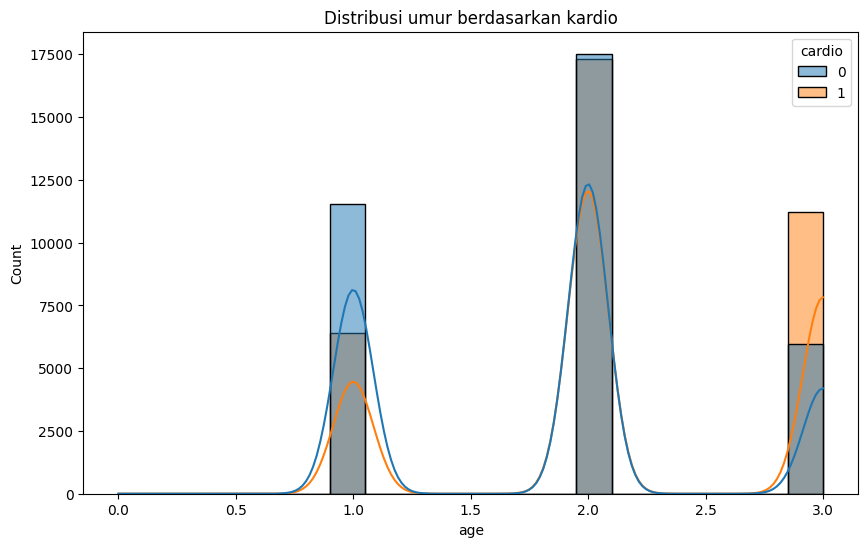

In [30]:
plt.figure(figsize=(10,6))
sns.histplot(data=cardio, x="age", hue="cardio", kde=True, bins=20)
plt.title("Distribusi umur berdasarkan kardio")
plt.show()

## Pengecekan Nilai NaN

In [31]:
nan_info = cardio.isnull().sum()
nan_columns = nan_info[nan_info > 0]
print("fitur dengan nilai NaN")
nan_columns

fitur dengan nilai NaN


Series([], dtype: int64)

## penghapusan fitur yang tidak relevan

In [32]:
cardio = cardio.drop(["id", "Unnamed: 0"], axis="columns")

In [33]:
cardio.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,2,1,168.0,62.0,110.0,80.0,0,0,0,0,1,0
1,2,0,156.0,85.0,140.0,90.0,2,0,0,0,1,1
2,2,0,165.0,64.0,130.0,70.0,2,0,0,0,0,1
3,1,1,169.0,82.0,150.0,100.0,0,0,0,0,1,1
4,1,0,156.0,56.0,100.0,60.0,0,0,0,0,0,0


## Spliting data

In [36]:
X = cardio.drop("cardio", axis="columns")
y = cardio['cardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(56000, 11)
(14000, 11)
(56000,)
(14000,)


## Standarisasi Z-Score 

In [37]:
scaler = StandardScaler()
columns = ["height", "weight", "ap_hi", "ap_lo"]

non_binary_columns = [ col for col in X_train.columns if col in columns]
scaler.fit(X_train[non_binary_columns])
X_train[non_binary_columns] = scaler.transform(X_train[non_binary_columns])
X_train
# fitur_scale = []

# for data in X_train.columns:
#     if X_train[data].min() < 0 or X_train[data].max() > 1:
#         fitur_scale.append(data)
# scaler.fit(X_train[fitur_scale])
# X_train[fitur_scale] = scaler.transform(X_train[fitur_scale])
# X_train

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
57050,2,0,-1.020082,-0.087893,-0.058621,-0.086929,1,0,0,0,1
66119,2,1,0.928171,0.258399,0.146192,0.017852,0,0,1,1,1
2762,3,0,-0.898317,-0.988254,-0.195164,-0.191710,1,0,0,0,1
6182,2,1,0.441108,0.050624,-0.058621,-0.086929,0,0,0,0,1
35804,3,1,0.197576,-0.711220,0.146192,-0.034538,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
49100,2,1,1.293468,0.258399,-0.058621,-0.086929,0,0,0,0,1
20609,2,0,-0.045956,-0.434186,-0.058621,-0.086929,0,0,0,0,0
21440,2,1,1.658766,0.535434,-0.058621,-0.086929,0,0,0,0,1
50057,3,0,0.562873,0.189141,-0.058621,-0.086929,0,0,0,0,0


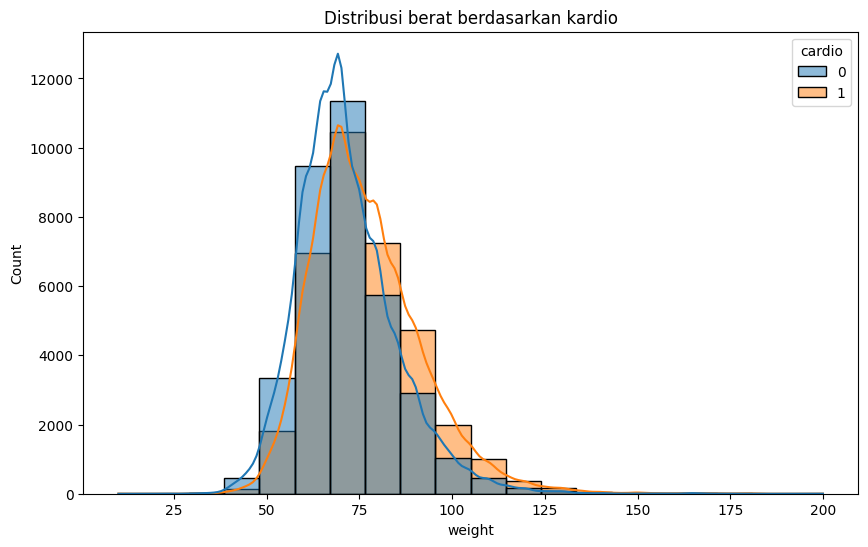

In [40]:
plt.figure(figsize=(10,6))
sns.histplot(data=cardio, x="weight", hue="cardio", kde=True, bins=20)
plt.title("Distribusi berat berdasarkan kardio")
plt.show()

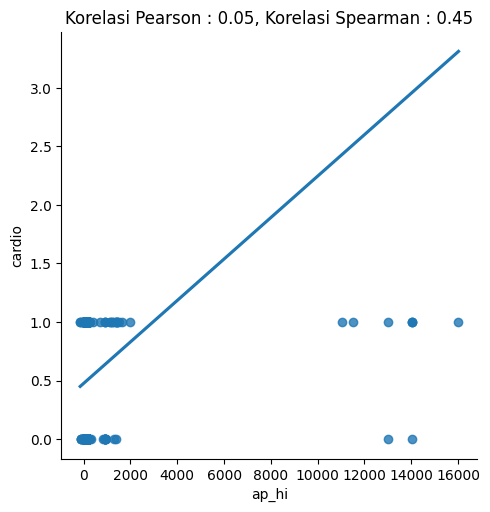

In [44]:
pearson_corr, p_value = pearsonr(cardio["ap_hi"], cardio["cardio"])
spearman_corr, _ = spearmanr(cardio["ap_hi"], cardio["cardio"])

sns.lmplot(x="ap_hi", y="cardio", data=cardio, ci=None)
plt.title(f"Korelasi Pearson : {pearson_corr:.2f}, Korelasi Spearman : {spearman_corr:.2f}")
plt.xlabel("ap_hi")
plt.ylabel("cardio")
plt.show()

## Balancing Data

In [45]:
print(X_train.shape)
print(y_train.shape)

(56000, 11)
(56000,)


In [46]:
ros = RandomOverSampler(random_state=1)
X_resample, y_resample = ros.fit_resample(X_train, y_train)
print(X_resample.shape)
print(y_resample.shape)

(56208, 11)
(56208,)


## Normalisasi untuk data testing

In [47]:
X_test[non_binary_columns] = scaler.transform(X_test[non_binary_columns])
X_test

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
6670,1,0,-1.385380,1.297277,0.077921,-0.034538,0,0,0,0,1
49567,1,0,-0.898317,1.020243,-0.058621,-0.086929,0,0,0,0,1
50796,2,0,0.075810,-0.572703,0.146192,-0.034538,0,0,0,0,1
22310,2,1,1.415234,0.950985,0.214463,0.017852,1,1,1,1,1
54037,1,1,0.075810,0.258399,0.077921,-0.034538,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
35736,3,1,1.780532,0.743209,-0.058621,-0.086929,0,0,1,0,0
45283,1,0,-0.167722,0.119882,-0.058621,-0.086929,0,0,0,0,0
1541,1,0,0.197576,-0.503444,-0.058621,-0.086929,0,0,0,0,1
51612,1,0,-1.141848,-1.334547,-0.126893,-0.034538,0,0,0,0,1


## Modeling menggunakan SVM

In [48]:
svm_model = SVC(kernel="linear", C=1.0, random_state=42, class_weight="balanced")
svm_model.fit(X_resample, y_resample)

SVC(class_weight='balanced', kernel='linear', random_state=42)

## Akurasi

In [49]:
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7248571428571429

## mengukur confusion matrix

In [50]:
conf = confusion_matrix(y_test, y_pred)
conf

array([[5646, 1271],
       [2581, 4502]])

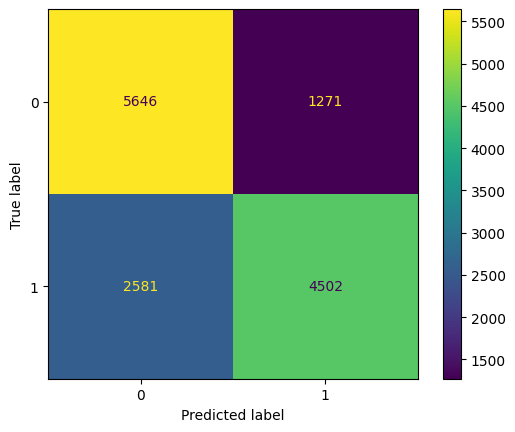

In [51]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf, display_labels = [0, 1])
cm_display.plot()
plt.show()